/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/3200387973.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Predicted Label: cephalophus nigrifrons, Confidence: 0.8405


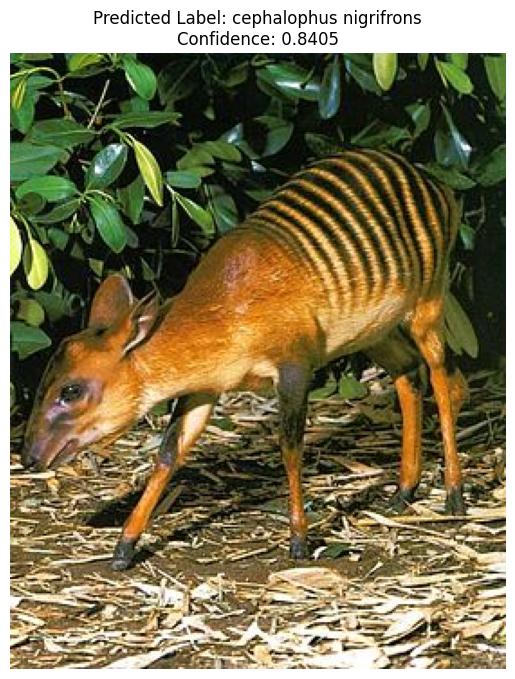

In [1]:
import torch
from torchvision import transforms, models
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import json
import pandas as pd
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
import random

# Import the nn module from torch.nn
import torch.nn as nn

def load_model(checkpoint_path, num_classes):
    model = models.efficientnet_b6(pretrained=False)
    model.classifier = nn.Linear(2304, num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def preprocess_image(image_path, mean, std):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

def predict(model, image, device):
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
    return outputs

def postprocess_predictions(outputs):
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_label = predicted_idx.item()
    confidence = probabilities[0, predicted_idx].item()
    return predicted_label, confidence

def load_category_mapping(data_path):
    with open(data_path) as f:
        data = json.load(f)

    annotations = pd.DataFrame.from_dict(data["annotations"])
    categories = pd.DataFrame.from_dict(data["categories"])
    category_mapping = {row['id']: row['name'] for _, row in categories.iterrows()}

    unique_classes = annotations["category_id"].unique()
    category_to_index = {
        category_id: index for index, category_id in enumerate(unique_classes)
    }

    annotations["mapped_category_id"] = annotations["category_id"].map(
        category_to_index
    )

    return category_to_index, category_mapping, annotations

def get_category_name(prediction_label, annotations, category_mapping):
    category_id = annotations.loc[annotations["mapped_category_id"] == prediction_label, "category_id"].values[0]
    predicted_label = category_mapping.get(category_id, "Unknown label")
    return predicted_label

def inference(image_path, checkpoint_path, num_classes, data_path, mean, std, device=torch.device('cpu')):
    model = load_model(checkpoint_path, num_classes)
    image = preprocess_image(image_path, mean, std)
    outputs = predict(model, image, device)
    predicted_label_id, confidence = postprocess_predictions(outputs)

    category_to_index, category_mapping, annotations = load_category_mapping(data_path)
    predicted_label = get_category_name(predicted_label_id, annotations, category_mapping)

    return predicted_label, confidence

def show_visualization(image_path, predicted_label, confidence):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Label: {predicted_label}\nConfidence: {confidence:.4f}", fontsize=12)
    plt.show()

# Example usage
if __name__ == "__main__":
    image_path = "/kaggle/input/dukerrrr/Cephalophus_zebra.jpg"
    checkpoint_path = "/kaggle/input/efficientnet/pytorch/default/1/best-effnetb6-baseline.pt_20241125_132008.pt"
    num_classes = 216
    data_path = "/kaggle/input/annotations/iwildcam2020_train_annotations.json"
    mean = [2.9317e-09, 2.8943e-09, 2.8340e-09]  
    std = [1.3166e-09, 1.3476e-09, 1.4205e-09] 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predicted_label, confidence = inference(image_path, checkpoint_path, num_classes, data_path, mean, std, device)
    print(f"Predicted Label: {predicted_label}, Confidence: {confidence:.4f}")
    
    # Show visualization
    show_visualization(image_path, predicted_label, confidence)